## Análise exploratória

### Template - Predição climática

---

Instalar e importar dependências:

In [1]:
# !pip install awswrangler

In [2]:
import os
import sys
import time
import boto3
import numpy as np
import pandas as pd
from io import StringIO
import awswrangler as wr
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

sys.path.append(os.path.dirname(os.getcwd())+'/src')
import get_data

In [3]:
session = boto3.Session()
print(session)

Session(region_name='us-east-1')


Dados do projeto:

In [4]:
project_name = 'ds-mlops'

---

Criar um bucket para armazenar dados dos experimentos (se ainda não existir):

In [5]:
bucket = 'ons-{}'.format(project_name)

try:
    if session.region_name == 'us-east-1':
        session.client('s3').create_bucket(Bucket=bucket)
    else:
        session.client('s3').create_bucket(Bucket=bucket)

except Exception as e:
    print(e)

---

### Leitura dos dados

In [6]:
bucket = 'ons-ds-mlops'
file_path = 'framework-overview/data/raw/weather.csv'
df = get_data.read_csv(bucket, file_path)
df.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


---

### Análise do dataset

In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB
None


dtypes - tipos de variáveis:

descrição - propriedades estatísticas de informações numéricas:

In [8]:
print(df.describe())

       precipitation     temp_max     temp_min         wind
count    1461.000000  1461.000000  1461.000000  1461.000000
mean        3.029432    16.439083     8.234771     3.241136
std         6.680194     7.349758     5.023004     1.437825
min         0.000000    -1.600000    -7.100000     0.400000
25%         0.000000    10.600000     4.400000     2.200000
50%         0.000000    15.600000     8.300000     3.000000
75%         2.800000    22.200000    12.200000     4.000000
max        55.900000    35.600000    18.300000     9.500000


value_counts - visualizar categorias da coluna weather.

In [9]:
print(df['weather'].value_counts())

rain       641
sun        640
fog        101
drizzle     53
snow        26
Name: weather, dtype: int64


intervalo de datas:

In [10]:
print('data inicial: ', min(df['date']))
print('data final: ', max(df['date']))

data inicial:  2012-01-01
data final:  2015-12-31


---

### Visualização de dados

Distribuição de máximas e mínimas de temperatura:

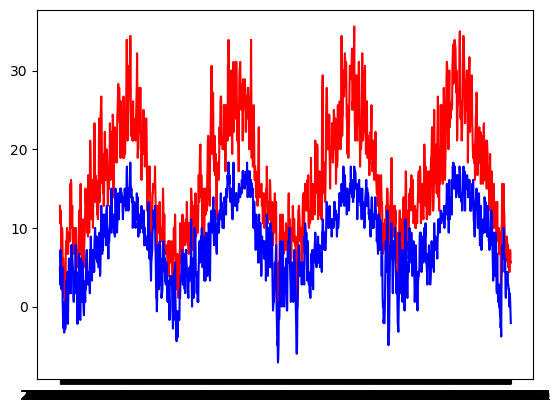

In [11]:
plt.plot(df['date'],df['temp_max'], color='red')
plt.plot(df['date'],df['temp_min'], color='blue')
plt.show()

distribuição de velocidade do vento:

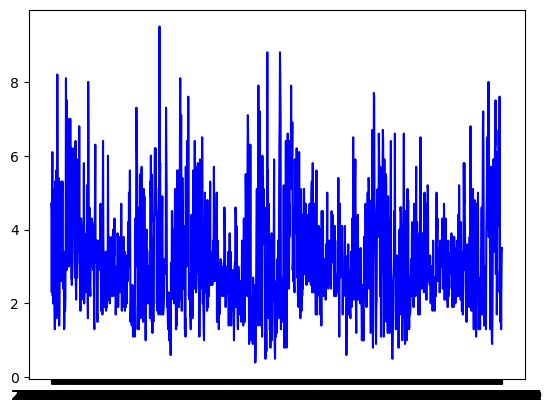

In [12]:
plt.plot(df['date'],df['wind'], color='blue')
plt.show()

distribuição de precipitação:

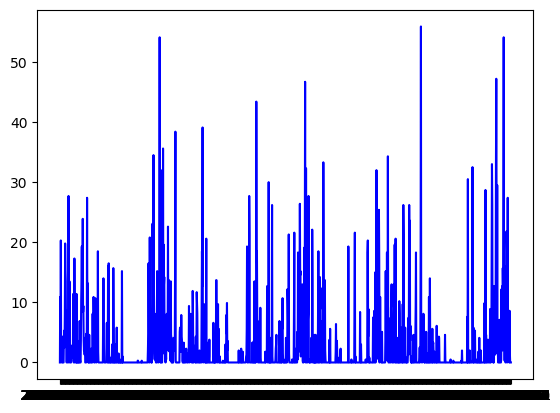

In [13]:
plt.plot(df['date'],df['precipitation'], color='blue')
plt.show()

distribuição das categorias de clima:

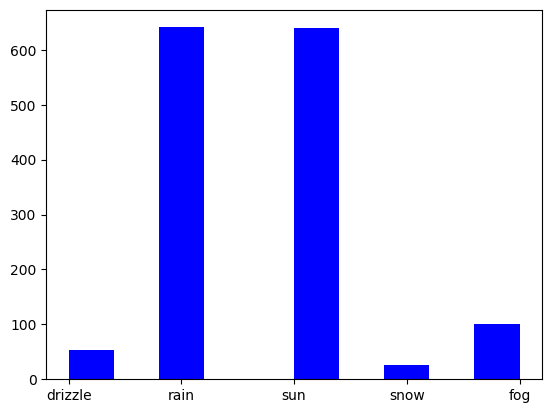

In [14]:
plt.hist(df['weather'], color='blue')
plt.show()

---

### Criar sets de treinamento e validação

In [15]:
target = 'weather'
features = [i for i in df.columns if i != target]
print('target: ', target, ', features: ', features)

target:  weather , features:  ['date', 'precipitation', 'temp_max', 'temp_min', 'wind']


In [16]:
# training set
x_train = df[df['date']<'2015-01-01'][features].copy()
y_train = df[df['date']<'2015-01-01'][['date',target]].copy()
print(x_train.shape, y_train.shape)

(1096, 5) (1096, 2)


In [17]:
# validation set
x_val = df[df['date']>='2015-01-01'][features].copy()
y_val = df[df['date']>='2015-01-01'][['date',target]].copy()
print(x_val.shape, y_val.shape)

(365, 5) (365, 2)


---

### Engenharia de Features

Criação de uma feature com o delta de temperatura:

In [18]:
def set_date_index(X):
    X['date'] = pd.to_datetime(X['date'])
    X = X.set_index('date')
    return X

In [19]:
x_train = set_date_index(x_train)
y_train = set_date_index(y_train)
x_train

,precipitation,temp_max,temp_min,wind
date,,,,
2012-01-01,0.0,12.8,5.0,4.7
2012-01-02,10.9,10.6,2.8,4.5
2012-01-03,0.8,11.7,7.2,2.3
2012-01-04,20.3,12.2,5.6,4.7
2012-01-05,1.3,8.9,2.8,6.1
...,...,...,...,...
2014-12-27,3.3,9.4,4.4,4.9
2014-12-28,4.1,6.7,2.8,1.8
2014-12-29,0.0,6.1,0.6,4.3


In [20]:
def create_temperature_delta(X):
    X['temp_delta'] = X['temp_max'] - X['temp_min']
    return X

In [21]:
def create_temperature_mean(X):
    X['temp_mean'] = (X['temp_max'] + X['temp_min'])/2
    return X

In [22]:
x_train = create_temperature_delta(x_train)
x_train = create_temperature_mean(x_train)

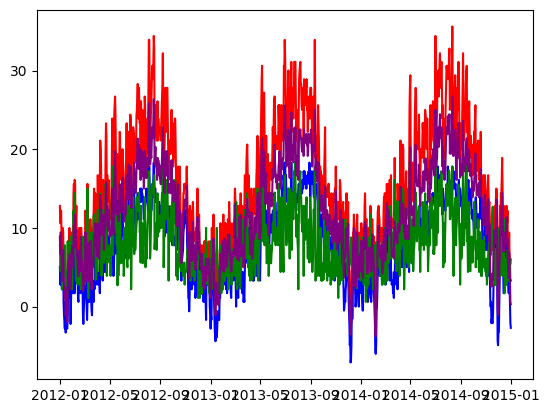

In [23]:
plt.plot(x_train.index,x_train['temp_max'], color='red')
plt.plot(x_train.index,x_train['temp_min'], color='blue')
plt.plot(x_train.index,x_train['temp_delta'], color='green')
plt.plot(x_train.index,x_train['temp_mean'], color='purple')
plt.show()

Criação de uma feature cíclica para a variável temporal:

In [24]:
def create_cyclical_from_time(X, initial_date):
    X_aux = X.copy()
    X_aux['time_delta'] = X_aux.index -  initial_date
    X['cyclical_date'] = X_aux['time_delta']
    X['cyclical_date'] = X['cyclical_date'].apply(lambda x:x.days)
    X['cyclical_date'] = np.cos(X['cyclical_date']*(2*np.pi/(365.25)))
    return X

In [25]:
x_train = create_cyclical_from_time(X=x_train, initial_date=x_train.iloc[0].name)

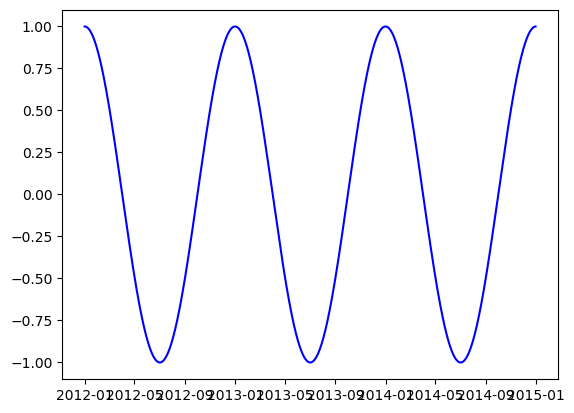

In [26]:
plt.plot(x_train.index, x_train['cyclical_date'], color='blue')
plt.show()

Agregando informações em janelas de tempo pré-definidas:

In [27]:
# def aggregate_temperatures(X_):
#     X_['avg_l3_temp_max'] = X_.apply(lambda x: X_['temp_max'][(pd.to_datetime(X_.index) < x.name)].tail(3).sum()/3, axis = 1)
#     X_['avg_l3_temp_min'] = X_.apply(lambda x: X_['temp_min'][(pd.to_datetime(X_.index) < x.name)].tail(3).sum()/3, axis = 1)
#     X_['avg_l3_temp_delta'] = X_.apply(lambda x: X_['temp_delta'][(pd.to_datetime(X_.index) < x.name)].tail(3).sum()/3, axis = 1)
#     return X_

In [28]:
# x_train = aggregate_temperatures(x_train)
# x_train

Transformando o target em uma informação numérica:

In [29]:
def encode_target(Y):    
    translation_dict = {
        'snow':0,
        'rain':1,
        'drizzle':2,
        'fog':3,
        'sun':4
    }
    Y['weather'] = Y['weather'].apply(lambda x:translation_dict[x])
    return Y

In [30]:
y_train = encode_target(y_train)
y_train

,weather
date,
2012-01-01,2
2012-01-02,1
2012-01-03,1
2012-01-04,1
2012-01-05,1
...,...
2014-12-27,1
2014-12-28,1
2014-12-29,3


---

### Análise de correlação

In [31]:
cor = pd.concat([x_train, y_train], axis=1)
cor = cor.corr()
cor.style.background_gradient(cmap='coolwarm')

,precipitation,temp_max,temp_min,wind,temp_delta,temp_mean,cyclical_date,weather
precipitation,1.000000,-0.222654,-0.068106,0.288379,-0.338943,-0.164498,0.206065,-0.479274
temp_max,-0.222654,1.000000,0.874760,-0.187884,0.761959,0.978871,-0.813779,0.428650
temp_min,-0.068106,0.874760,1.000000,-0.102101,0.352720,0.955359,-0.759022,0.198550
wind,0.288379,-0.187884,-0.102101,1.000000,-0.226363,-0.157644,0.157719,-0.261281
temp_delta,-0.338943,0.761959,0.352720,-0.226363,1.000000,0.613432,-0.557035,0.562399
temp_mean,-0.164498,0.978871,0.955359,-0.157644,0.613432,1.000000,-0.816486,0.345146
cyclical_date,0.206065,-0.813779,-0.759022,0.157719,-0.557035,-0.816486,1.000000,-0.327854
weather,-0.479274,0.428650,0.198550,-0.261281,0.562399,0.345146,-0.327854,1.000000


Os campos de temperatura máxima e mínima têm um alto grau de colinearidade (0.874760). Essas mesmas informações podem ser aproximadas através das informações de temperatura média e delta de temperatura, que apresentam um menor grau de colinearidade (0.761959). Neste sentido, é conveniente usar temperatura média e delta de temperatura ao invés de temperatura máxima e temperatura mínima.

In [32]:
def select_features(X):
    X = X.drop(columns=['temp_max','temp_min'])
    return X

In [33]:
x_train = select_features(x_train)
x_train.head()

,precipitation,wind,temp_delta,temp_mean,cyclical_date
date,,,,,
2012-01-01,0.0,4.7,7.8,8.90,1.000000
2012-01-02,10.9,4.5,7.8,6.70,0.999852
2012-01-03,0.8,2.3,4.5,9.45,0.999408
2012-01-04,20.3,4.7,6.6,8.90,0.998669
2012-01-05,1.3,6.1,6.1,5.85,0.997634


---

### Pairplot

In [34]:
import seaborn as sn

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


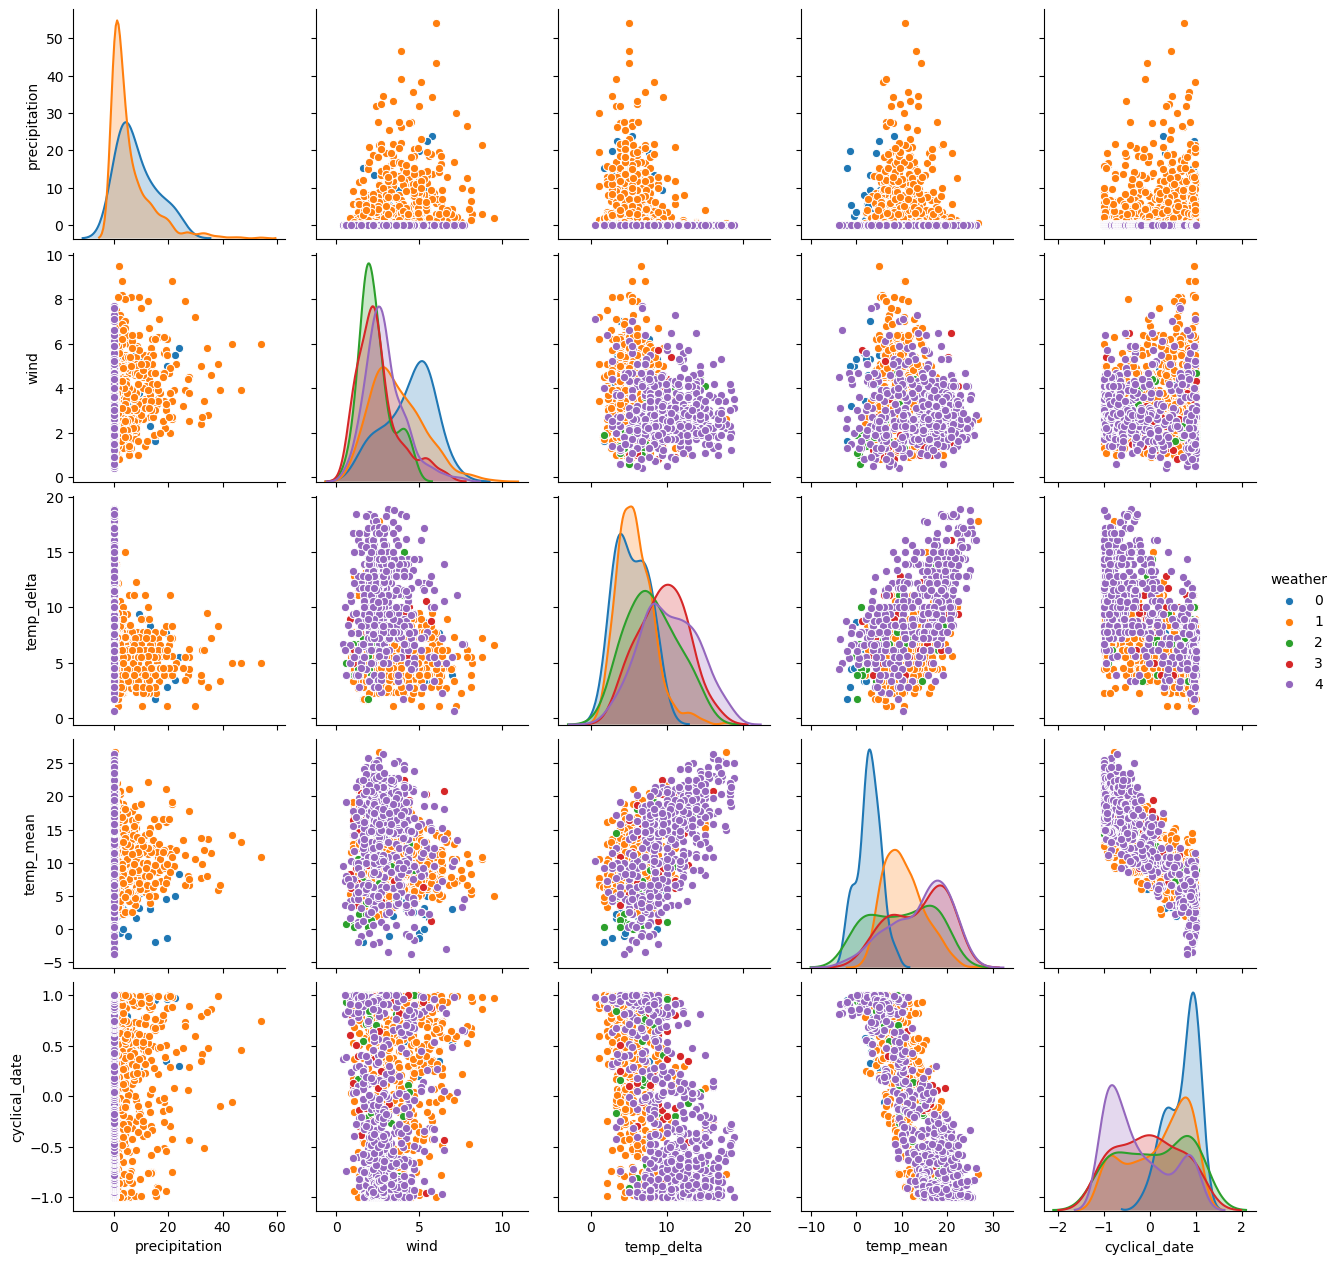

In [35]:
sn.pairplot(pd.concat([x_train, y_train], axis=1), hue='weather')
plt.show()

---

### Observações finais

As features produzidas parecem separar de forma satisfatória os diferentes valores do target. Os insumos produzidos nesta análise podem ser usados para construção do pipeline de engenharia de features e para a etapa de modelagem.